<a href="https://colab.research.google.com/github/tusharkj14/Knowledge_Graph_Start/blob/main/KnowledgeGraphOne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
  
  
uploaded = files.upload()

Saving wiki_sentences_v2.csv to wiki_sentences_v2.csv


In [ ]:
import pandas as pd
import io

df = pd.read_csv(io.BytesIO(uploaded['wiki_sentences_v2.csv']))

In [ ]:
df.head()

,sentence
0,"confused and frustrated, connie decides to lea..."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."


In [ ]:
import spacy
from spacy import displacy 
nlp = spacy.load('en_core_web_sm')

In [ ]:
df['sentence'].sample(5)

3598    it consists of an outer cubical shell  and the...
723     f. percy smith was an early nature documentary...
3621                 she also posed nude for photographs.
1767       the film was shot in cyprus, dubai and london.
710     technical improvements added length , synchron...
Name: sentence, dtype: object

In [ ]:
import re
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [ ]:
def reqd_ents(sent):
  ent1 = ent2 = ""
  prv_tok_dep = prv_tok_text = ""
  prefix = modifier = ""

  for token in nlp(sent):

    if token.dep_ != "punct":

      if token.dep_ == "compound": 

        prefix = token.text 

        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " " + token.text

      if token.dep_.endswith("mod"):
        modifier = token.text

        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " " + token.text

      if token.dep_.find("subj")==True:
        ent1 = modifier + " " + prefix + " " + token.text
        prefix = modifier = prv_tok_dep = prv_tok_text = ""

      if token.dep_.find("obj")==True:
        ent2 = modifier + " " + prefix + " " + token.text

      prv_tok_text = token.text
      prv_tok_dep = token.dep_

  return [ent1.strip(), ent2.strip()]

In [ ]:
reqd_ents("the film had 200 patents")

['film', '200  patents']

In [ ]:
entity_pairs = []

In [ ]:
for i in tqdm(df['sentence']):
  entity_pairs.append(reqd_ents(i))

100%|██████████| 4318/4318 [03:08<00:00, 22.96it/s]


In [ ]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['telepath', 'gallio'],
 ['singer', 'men']]

In [ ]:
from spacy.matcher import Matcher 
from spacy.tokens import Span 

In [ ]:
def get_rlns(sent):
  doc = nlp(sent)

  matcher = Matcher(nlp.vocab)

  pattern = [{'DEP': 'ROOT'},
             {'DEP': 'prep', 'OP':'?'},
             {'DEP':'agent','OP':"?"}, 
             {'POS':'ADJ','OP':"?"}
             ]

  matcher.add("matching_1", None, pattern)

  matches = matcher(doc)
  
  return doc[matches[-1][1]:matches[-1][2]].text

In [ ]:
get_rlns("Sixty Hollywood musicals were released in 1929")

'released in'

In [ ]:
for token in nlp(u'Sixty Hollywood musicals were released in 1929'):
  print(f'{token.text}--{token.dep_}')

Sixty--compound
Hollywood--compound
musicals--nsubjpass
were--auxpass
released--ROOT
in--prep
1929--pobj


In [ ]:
relations = [get_rlns(i) for i in tqdm(df['sentence'])]

100%|██████████| 4318/4318 [04:15<00:00, 16.90it/s]


In [ ]:
pd.Series(relations).value_counts()[:10]

is             370
was            297
released on     87
include         73
were            71
are             71
released        40
's              38
composed by     35
has             31
dtype: int64

In [ ]:
kg_df = pd.DataFrame({'source':[i[0] for i in entity_pairs],
                      'target':[i[1] for i in entity_pairs],
                      'edge':relations})

In [ ]:
kg_df

,source,target,edge
0,connie,own,decides
1,later woman,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,outside cult,him,wails with
...,...,...,...
4313,confidencial,negatively film,responded
4314,le parisien,five star rating,gave
4315,museum collection,"37,000 film titles",includes
4316,predecessor,historical film 1946,was


In [ ]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

In [ ]:
G.size()

4318

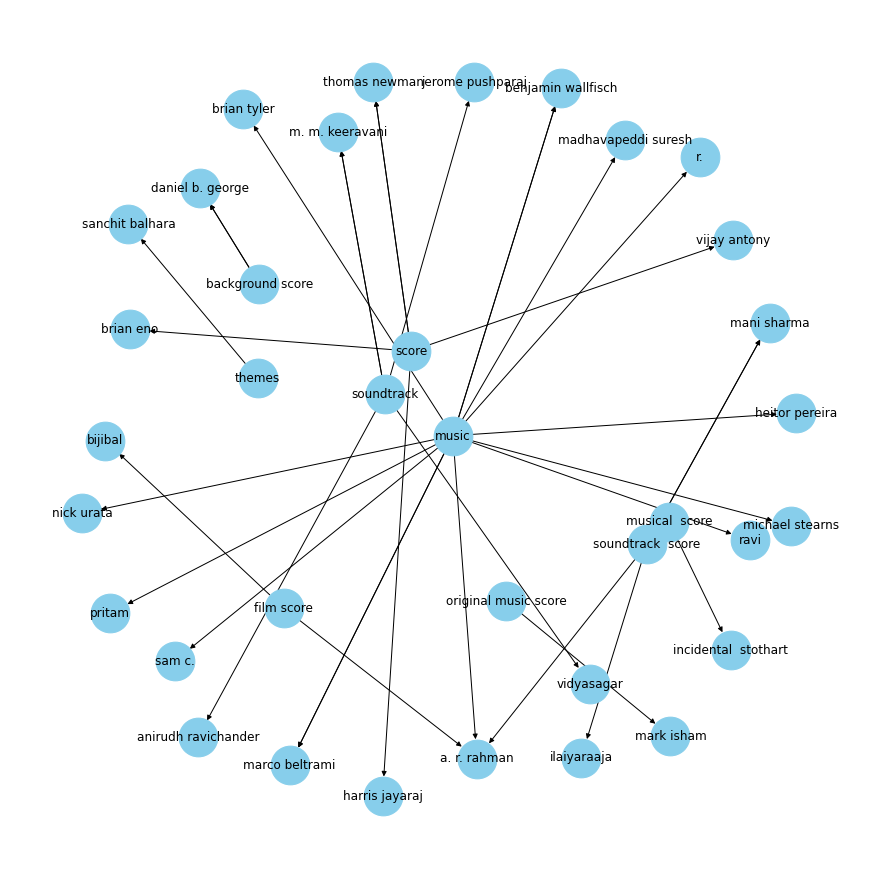

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"],
                          "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500,
        edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

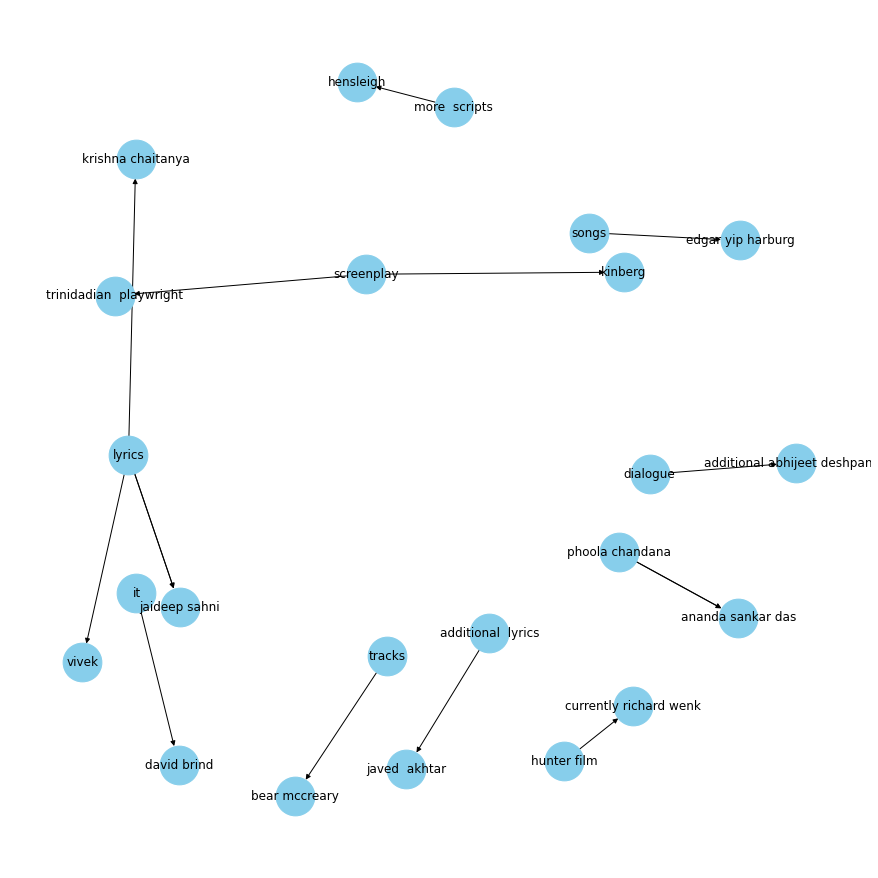

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()